# Smooth criminals: agent-based modeling of street crime

In [1]:
from __future__ import print_function, division

import random
import thinkplot
import numpy as np
from Cell2D import Cell2D, Cell2DViewer
from thinkstats2 import Cdf
from thinkstats2 import RandomSeed
import matplotlib.pyplot as plt
from matplotlib import rc
rc('animation', html='html5')

In `crimeworldnotebook-original.ipynb`, we replicated Groff's model and created `Citizen` agents and `CrimeWorld` (and its viewer, `CrimeWorldViewer`). In this notebook, we will extend this model to find out the effects of deterrent in the form of punishment for committing crimes. The point of introducing punishment to criminals is to lower the rate of crime. We will find out if this is the case and investigate the possibility of an optimization condition.

Two significant factors contribute to a criminal's motivation for committing crimes, which are necessity (how poor a criminal is) and confidence (how successful a criminal is). Only one factor, however, lowers a criminal's motivation, which is being punished. Depending on the degree of punishment, a criminal might either be more motivated to commit a crime (after losing too much wealth) or less motivated (after losing only some wealth).

In [2]:
class Citizen():
    """
    Represents a citizen in CrimeWorld.
    """
    def __init__(self, loc, home, wealth, income, time_from_home):
        self.loc = loc
        self.home = home
        self.wealth = wealth
        self.income = income
        self.time_from_home = 24*time_from_home
        
        self.motivation = random.randint(1,11)
        self.isPopo = False
        self.timeAway = 0
        self.isHome = False
        self.timeAtHome = 0 
        self.timesCaught = 0
        self.timesSuccessful = 0

    def step(self, n, cost_of_living):
        self.wealth += self.income # Get paid! (Income)
        self.wealth -= cost_of_living # Live a little! (Living expenses)
        
        if (self.wealth <= 0 and self.wealth > -5):
            self.motivation = self.motivation + 1
        elif (self.wealth <= -5):
            self.motivation = self.motivation + 2
        
        if (self.isHome):
            if (self.timeAtHome >= 24 - self.time_from_home):
                if (random.randint(0, 5) <= 2):
                    self.isHome = False # Leave home
                    self.timeAtHome = 0
                else:
                    self.timeAtHome += 1
            else:
                self.timeAtHome += 1
        else:
            if (self.timeAway >= self.time_from_home):
                self.isHome = True # Return home
                self.timeAway = 0
                self.loc = self.home
            else:
                self.timeAway += 1
                directions = [[0,5], [0,-5], [5,0], [-5,0]]
                index = np.random.randint(4)
                new_loc = np.add(self.loc, directions[index])
                while (new_loc[0] < 0 or new_loc[1] < 0 or
                      new_loc[0] >= n or new_loc[1] >= n):
                    index = np.random.randint(4)
                    new_loc = np.add(self.loc, directions[index])
                self.loc = new_loc
                if (self.timeAway % 5 == 0):
                    self.motivation += 1

    def getRobbed(self):
        self.wealth -= 6

    def rob(self):
        self.wealth += 6
        self.timesSuccessful += 1

    def decideToOffend(self, agents):
        if (self.motivation >= 10):
            return True
        
        capability = random.randint(-2, 2)
        G = len(agents) - 2 + capability
        if G > 1:
            return False
        elif G == 1:
            p = random.choice([True, False])
            return p
        return True
  
    def setHome(self, state):
        self.isHome = state
    
    def setPopo(self, state):
        self.isPopo = state    

    def pickChump(self, agents):
        if (agents != []):
            return max(agents, key= lambda x: x.wealth)
    
    def getPunished(self, factor):
        self.wealth -= factor # * self.wealth
        if (self.timesSuccessful > self.timesCaught):
            self.motivation -= 1
        else:
            self.motivation = self.calcMotivation()
        
    def calcMotivation(self):
        self.motivation -= ((self.timesCaught - self.timesSuccessful) * self.motivation)/(self.timesSuccessful + 1)
        return self.motivation

Now, we need to create the world that all these citizens live in. `CrimeWorld` is based on `Cell2D` and LA's real-world properties. In `CrimeWorld`, we keep track of the locations of all citizens and crimes in an array, where each cell represents the location of a street intersection.

In [4]:
class CrimeWorld(Cell2D):
    """
    Represents the world in which our simulation takes place.
    """

    def __init__(self, n, **params):
        """
        Initializes the attributes.
  
        n: number of rows and columns
        params: dictionary of parameters
            -num_citizens
            -num_police
            -prop_criminals
        """
        self.params = params
        self.array = np.zeros(shape=(n,n))
        self.make_agents(n)
        self.n = n
        self.agent_count_seq = [] # track variables
        self.total_robs = 0
        self.rob_count_seq = []
        self.total_wealth = 0
  
    def make_locs(self, n, m):
        """
        Makes array where each row is an index in an `n` by `m` grid.
    
        n: int number of rows
        m: int number of cols
    
        returns: NumPy array
        """
        left = np.repeat(np.arange(m), n)
        right = np.tile(np.arange(n), m)
        return np.transpose([left, right])

    def make_agents(self, n):
        """
        Makes the agents.
        Each Citizen starts out with a different wealth and a different income in order to generate inequality.
        Their incomes are set, where each is on a scale from 0 (unemployed) to 18 (high pay).
        This is based on Seattle's average income per hour.
        """
  
        # determine where the agents start and generate locations
        locs = self.make_locs(n, n)
        np.random.shuffle(locs)
                
        # make the agents
        num_citizens = self.params.get('num_citizens', 1000)
        num_police = self.params.get('num_police', 200)
        time_from_home = self.params.get('time_from_home', 0.3)
        self.citizens = [Citizen(locs[i], locs[i], random.randint(0, 50), random.randint(0, 18), time_from_home = random.randint(3, 7)/10)
                            for i in np.random.choice(range(len(locs)), num_citizens)]
        for citizen in random.sample(self.citizens, num_police):
            citizen.setPopo(True)  # set police
  
    def step(self):
        num_citizens = float(self.params.get('num_citizens', 1000))
        prop_criminals = self.params.get('prop_criminals', 0.2)
        punishment_factor = self.params.get('punishment_factor', 0.7)
        for citizen in self.citizens:
            citizen.step(self.n, random.randint(4, 8))
            
        potential_criminals = random.sample(self.citizens, int(prop_criminals * num_citizens)) # Not everyone's a criminal
        for potential_criminal in potential_criminals:
            hasPopo = False
            citizens_in_node = []
            for x in self.citizens:
                if np.array_equal(x.loc,potential_criminal.loc) and not x.isHome:
                    citizens_in_node.append(x)
                    if x.isPopo:
                        hasPopo = True

            if not potential_criminal.isHome and potential_criminal.decideToOffend(citizens_in_node):
                if hasPopo:
                    potential_criminal.getPunished(punishment_factor)
                else:
                    target = potential_criminal.pickChump(citizens_in_node)
                    if (target != None and not target.isHome):
                        potential_criminal.rob()
                        target.getRobbed()
                        self.array[target.loc[0]][target.loc[1]] += 1
                        self.total_robs += 1
                        
                        if potential_criminal.timesSuccessful <= potential_criminal.timesCaught:
                            potential_criminal.motivation += 1
                        else:
                            potential_criminal.motivation = potential_criminal.calcMotivation()
    
        self.rob_count_seq.append(self.total_robs)

We can view the results of our simulation using the `CrimeWorldViewer` below.

In [5]:
class CrimeWorldViewer(Cell2DViewer):
    """Generates visualization and animation of CrimeWorld.
    Based on code from Think Complexity by Allen Downey."""

    cmap = plt.get_cmap('Greens')

    options = dict(interpolation='none', alpha=0.8,
                   vmin=0, vmax=7)

    def draw(self, grid=False):
        #TODO: draw robberies
        """Draws the array and any other elements.

        grid: boolean, whether to draw grid lines
        """
        self.draw_array(self.viewee.array, origin='lower')
        self.draw_agents()

    def draw_agents(self):
        """Plots the agents.
        """
        self.points = plt.plot(0,0,'.', color='red')[0]
        plt.show()

    def animate_func(self, i):
        """Draws one frame of the animation."""
        Cell2DViewer.animate_func(self, i)
        xs, ys = self.get_coords()
        self.points.set_data(np.array([xs, ys]))
        return self.im, self.points

    def get_coords(self):
        """Gets the coordinates of the agents.

        Transforms from (row, col) to (x, y).

        returns: tuple of sequences, (xs, ys)
        """
        agents = self.viewee.citizens
        new_array = np.zeros((1,2))
        rows, cols = np.transpose([new_array for agent in agents])
        xs = cols + 0.5
        ys = rows + 0.5
        return xs, ys

In [6]:
RandomSeed(100)
results = []
f_ar = range(0, 100, 10)
for f in f_ar:
    env = CrimeWorld(127, num_citizens=1000, prop_criminals=0.2, num_police=200, punishment_factor=f, time_from_home = 0.3)
    for i in range(100):
        env.step()

    print(env.total_robs)
    results.append(env.total_robs)

8197
8136
8213
8137
8193
8116
8182
8377
8093
8184


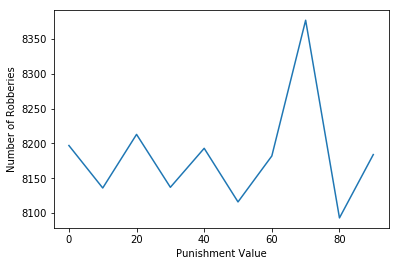

In [7]:
plt.plot(f_ar, results)
plt.xlabel('Punishment Value')
plt.ylabel('Number of Robberies')

plt.savefig("punishment_values.png")
plt.show()

In [10]:
class RobinHood(Citizen):
    """
    Defines a citizen who loses a percentage of their wealth every time they are caught.
    (This is a behavior opposed to having a fixed amount of their wealth removed.)
    """
    
    def __init__(self, loc, home, wealth, income, time_from_home):
        Citizen.__init__(self, loc, home, wealth, income, time_from_home)
    
    def getPunished(self, factor):
        self.wealth -= factor * self.wealth
        if (self.timesSuccessful > self.timesCaught):
            self.motivation -= 1
        else:
            self.motivation = self.calcMotivation()

In [11]:
class SherwoodForest(CrimeWorld):
    def __init__(self, n, **params):
        self.params = params
        CrimeWorld.__init__(self, n, **params)
        
    def make_agents(self, n):
        """
        Makes the agents.
        Each Citizen starts out with a different wealth and a different income in order to generate inequality.
        Their incomes are set, where each is on a scale from 0 (unemployed) to 18 (high pay).
        This is based on Seattle's average income per hour.
        """
  
        # determine where the agents start and generate locations
        locs = self.make_locs(n, n)
        np.random.shuffle(locs)
                
        # make the agents
        num_citizens = self.params.get('num_citizens', 1000)
        num_police = self.params.get('num_police', 200)
        time_from_home = self.params.get('time_from_home', 0.3)
        self.citizens = [RobinHood(locs[i], locs[i], random.randint(0, 50), random.randint(0, 18), time_from_home = random.randint(3, 7)/10)
                            for i in np.random.choice(range(len(locs)), num_citizens)]
        for citizen in random.sample(self.citizens, num_police):
            citizen.setPopo(True)  # set police

In [12]:
RandomSeed(100)
results = []
f_ar = range(0, 10, 1)
for f in f_ar:
    env = SherwoodForest(127, num_citizens=1000, prop_criminals=0.2, num_police=200, punishment_factor=f/10, time_from_home = 0.3)
    for i in range(100):
        env.step()

    print(env.total_robs)
    results.append(env.total_robs)

8197
8080
8395
8181
8165
8015
8173
8173
8159
8198


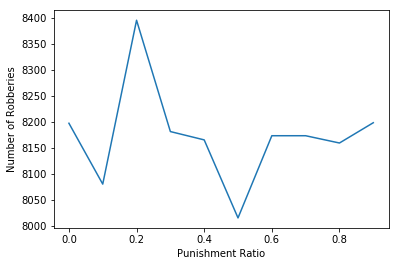

In [13]:
plt.plot(np.divide(f_ar, 10), results)
plt.xlabel('Punishment Ratio')
plt.ylabel('Number of Robberies')

plt.savefig("punishment_ratio1.png")
plt.show()